# Worked Example: Failure Modeling with EUL + Condition Score

This notebook shows a basic reliability workflow for two valve asset types:

- `bfly valves`: many assets and many failures (well tracked)
- `surge valves`: few assets and few failures (sparse)

We model failure time with a Weibull proportional-hazards model:

$$
h(t \mid c) = h_0(t)\exp\left(\beta(c - 1)\right)
$$

where:

- $h_0(t) = \frac{k}{\eta}\left(\frac{t}{\eta}\right)^{k - 1}$ is the Weibull baseline hazard
- $c$ is condition score (1 to 5)
- $c = 1$ is the baseline hazard level
- each +1 condition step multiplies hazard by $\exp(\beta)$

Supplier End-of-Useful-Life (EUL) estimates are incorporated as priors on the
Weibull scale parameter.

In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## 1. Generate a 10-year work-order style dataset

In real use, replace this section with your actual asset registry + work orders.

In [2]:
OBSERVATION_YEARS = 10.0
BASE_INSTALL_DATE = pd.Timestamp("2016-01-01")
RNG = np.random.default_rng(7)
# `0.5` means supplier EUL is interpreted as median life: S(EUL) = 0.5.
EUL_SURVIVAL_PROBABILITY = 0.5


def simulate_asset_history(
    asset_type: str,
    n_assets: int,
    true_k: float,
    true_eta: float,
    true_beta: float,
) -> pd.DataFrame:
    """Simulate first-failure outcomes with right censoring at OBSERVATION_YEARS."""
    condition_score = RNG.integers(1, 6, size=n_assets)
    condition_centered = condition_score - 1

    u = RNG.random(n_assets)
    event_time_years = true_eta * (
        -np.log(u) / np.exp(true_beta * condition_centered)
    ) ** (1.0 / true_k)

    event_observed = event_time_years <= OBSERVATION_YEARS
    observed_years = np.minimum(event_time_years, OBSERVATION_YEARS)

    history = pd.DataFrame(
        {
            "asset_id": [f"{asset_type[:5].upper()}-{i:04d}" for i in range(n_assets)],
            "asset_type": asset_type,
            "condition_score": condition_score,
            "event_observed": event_observed.astype(int),
            "observed_years": observed_years,
        }
    )

    history["install_date"] = BASE_INSTALL_DATE
    history["last_observation_date"] = history["install_date"] + pd.to_timedelta(
        history["observed_years"] * 365.25,
        unit="D",
    )
    history["work_order_date"] = pd.NaT
    failure_mask = history["event_observed"] == 1
    history.loc[failure_mask, "work_order_date"] = history.loc[
        failure_mask,
        "last_observation_date",
    ]

    return history


bfly_history = simulate_asset_history(
    asset_type="bfly valves",
    n_assets=420,
    true_k=2.0,
    true_eta=16.0,
    true_beta=0.55,
)

surge_history = simulate_asset_history(
    asset_type="surge valves",
    n_assets=28,
    true_k=2.0,
    true_eta=20.0,
    true_beta=0.55,
)

history = pd.concat([bfly_history, surge_history], ignore_index=True)

history.groupby("asset_type")["event_observed"].agg(["count", "sum"])

,count,sum
asset_type,,
bfly valves,420,290
surge valves,28,13


`sum` is the number of failures captured in the 10-year observation window.
You should see many failures for `bfly valves` and only a handful for
`surge valves`.

## 2. Weibull + condition-score model with optional priors

For each asset record:

- $t_i$: observed time (failure or censoring)
- $d_i$: event flag (1 if failed, else 0)
- $x_i = \mathrm{condition\_score} - 1$ (so score $1$ is baseline)

Cumulative hazard is:

$$
H_i(t) = \left(\frac{t}{\eta}\right)^k \exp\left(\beta x_i\right)
$$

Supplier EUL is treated as a prior on `eta`. The parameter that controls how EUL
is interpreted is `EUL_SURVIVAL_PROBABILITY`.

- `EUL_SURVIVAL_PROBABILITY = 0.5` means EUL is median life ($S(\mathrm{EUL}) = 0.5$)
- change this value if supplier EUL should represent another quantile

In [3]:
def eul_to_log_eta_prior_mean(
    eul_years: float,
    eul_survival_probability: float = EUL_SURVIVAL_PROBABILITY,
    k_reference: float = 2.0,
) -> float:
    """Map EUL to log(eta) under a chosen Weibull survival quantile interpretation."""
    if not (0.0 < eul_survival_probability < 1.0):
        raise ValueError("eul_survival_probability must be between 0 and 1.")
    eta_from_eul = eul_years / (
        (-np.log(eul_survival_probability)) ** (1.0 / k_reference)
    )
    return float(np.log(eta_from_eul))


def negative_log_posterior(
    theta: np.ndarray,
    t: np.ndarray,
    d: np.ndarray,
    x: np.ndarray,
    log_eta_prior: tuple[float, float] | None,
    beta_prior: tuple[float, float] | None,
) -> float:
    """Negative log-posterior for Weibull PH with right censoring."""
    log_k, log_eta, beta = theta
    k = np.exp(log_k)
    eta = np.exp(log_eta)

    cumulative_hazard = ((t / eta) ** k) * np.exp(beta * x)
    log_hazard = np.log(k) - k * np.log(eta) + (k - 1.0) * np.log(t) + beta * x

    log_likelihood = np.sum(d * log_hazard - cumulative_hazard)

    # Weakly informative regularization for numerical stability.
    log_prior = 0.0
    log_prior += -0.5 * ((log_k - np.log(1.5)) / 1.5) ** 2
    log_prior += -0.5 * (beta / 2.0) ** 2

    if log_eta_prior is not None:
        mu_eta, sigma_eta = log_eta_prior
        log_prior += -0.5 * ((log_eta - mu_eta) / sigma_eta) ** 2

    if beta_prior is not None:
        mu_beta, sigma_beta = beta_prior
        log_prior += -0.5 * ((beta - mu_beta) / sigma_beta) ** 2

    return float(-(log_likelihood + log_prior))


def fit_weibull_ph(
    frame: pd.DataFrame,
    eul_years: float | None = None,
    eul_prior_sigma: float = 0.20,
    eul_survival_probability: float = EUL_SURVIVAL_PROBABILITY,
    use_condition: bool = True,
    beta_prior: tuple[float, float] | None = None,
) -> dict[str, float]:
    """Fit Weibull PH model by MAP optimization (or near-MLE with weak priors)."""
    t = frame["observed_years"].to_numpy(dtype=float)
    t = np.clip(t, 1e-6, None)
    d = frame["event_observed"].to_numpy(dtype=float)
    if use_condition:
        x = frame["condition_score"].to_numpy(dtype=float) - 1.0
    else:
        x = np.zeros_like(t)

    if d.sum() > 0:
        initial_eta = float(np.median(t[d == 1.0]))
    else:
        initial_eta = 20.0

    theta0 = np.array([np.log(1.2), np.log(max(initial_eta, 1.0)), 0.0])

    log_eta_prior = None
    if eul_years is not None:
        log_eta_prior = (
            eul_to_log_eta_prior_mean(
                eul_years,
                eul_survival_probability=eul_survival_probability,
            ),
            eul_prior_sigma,
        )

    result = minimize(
        negative_log_posterior,
        x0=theta0,
        args=(t, d, x, log_eta_prior, beta_prior),
        method="L-BFGS-B",
        bounds=[
            (np.log(0.2), np.log(8.0)),
            (np.log(1.0), np.log(100.0)),
            (-3.0, 3.0),
        ],
    )
    if not result.success:
        raise RuntimeError(f"Optimization failed: {result.message}")

    log_k, log_eta, beta = result.x
    k = float(np.exp(log_k))
    eta = float(np.exp(log_eta))

    return {
        "k": k,
        "eta": eta,
        "beta": float(beta),
        "hazard_ratio_per_condition_step": float(np.exp(beta)),
        "median_life_years": float(eta * (np.log(2.0) ** (1.0 / k))),
    }


def fit_weibull_no_condition(
    frame: pd.DataFrame,
    eul_years: float | None = None,
    eul_prior_sigma: float = 0.20,
    eul_survival_probability: float = EUL_SURVIVAL_PROBABILITY,
) -> dict[str, float]:
    """Fit Weibull baseline model with no condition effect."""
    return fit_weibull_ph(
        frame=frame,
        eul_years=eul_years,
        eul_prior_sigma=eul_prior_sigma,
        eul_survival_probability=eul_survival_probability,
        use_condition=False,
        beta_prior=(0.0, 0.05),
    )

## 3. Fit rich vs sparse asset types

We use this workflow:

1. Fit without EUL and without condition.
2. Add EUL prior only.
3. Add condition effect only.
4. Fit with both EUL and condition.

In [4]:
SUPPLIER_EUL_YEARS = {
    "bfly valves": 15.0,
    "surge valves": 12.0,
}

bfly_models = {
    "Without EUL & condition": fit_weibull_no_condition(
        bfly_history,
        eul_years=None,
    ),
    "With EUL only": fit_weibull_no_condition(
        bfly_history,
        eul_years=SUPPLIER_EUL_YEARS["bfly valves"],
    ),
    "With condition only": fit_weibull_ph(
        bfly_history,
        eul_years=None,
    ),
    "With EUL + condition": fit_weibull_ph(
        bfly_history,
        eul_years=SUPPLIER_EUL_YEARS["bfly valves"],
    ),
}

surge_models = {
    "Without EUL & condition": fit_weibull_no_condition(
        surge_history,
        eul_years=None,
    ),
    "With EUL only": fit_weibull_no_condition(
        surge_history,
        eul_years=SUPPLIER_EUL_YEARS["surge valves"],
    ),
    "With condition only": fit_weibull_ph(
        surge_history,
        eul_years=None,
    ),
    "With EUL + condition": fit_weibull_ph(
        surge_history,
        eul_years=SUPPLIER_EUL_YEARS["surge valves"],
    ),
}

all_models = {
    "bfly valves": bfly_models,
    "surge valves": surge_models,
}

results_rows = []
for asset_type, model_set in all_models.items():
    for model_name, params in model_set.items():
        results_rows.append(
            {
                "asset_type": asset_type,
                "model": model_name,
                **params,
            }
        )

results = pd.DataFrame(results_rows)

summary_counts = history.groupby("asset_type", as_index=False).agg(
    n_assets=("asset_id", "count"),
    failures=("event_observed", "sum"),
)

results.merge(summary_counts, on="asset_type").round(3)

,asset_type,model,k,eta,beta,hazard_ratio_per_condition_step,median_life_years,n_assets,failures
0,bfly valves,Without EUL & condition,1.768,9.003,0.000,1.000,7.318,420,290
1,bfly valves,With EUL only,1.760,9.180,0.000,1.000,7.454,420,290
2,bfly valves,With condition only,2.138,16.632,0.644,1.905,14.013,420,290
3,bfly valves,With EUL + condition,2.134,16.771,0.649,1.913,14.124,420,290
4,surge valves,Without EUL & condition,1.929,12.440,0.000,1.000,10.287,28,13
5,surge valves,With EUL only,1.832,13.288,0.000,1.000,10.878,28,13
6,surge valves,With condition only,2.201,28.647,0.739,2.094,24.253,28,13
7,surge valves,With EUL + condition,2.446,17.143,0.450,1.568,14.758,28,13


Interpretation:

- For `bfly valves` (many failures), the model variants are usually close.
- For `surge valves` (sparse), adding EUL and/or condition assumptions can
  materially shift parameter estimates.

## 4. Worked probability example

Compute next-year failure probability for an asset currently at age 9 years:

$$
P\left(t < T \le t+1 \mid T > t, c\right)
= 1 - \exp\left(-\left(H(t+1,c) - H(t,c)\right)\right)
$$

In [5]:
def conditional_failure_probability(
    model: dict[str, float],
    age_now: float,
    horizon: float,
    condition_score: int,
) -> float:
    """Failure probability between age_now and age_now+horizon conditional on survival."""
    k = model["k"]
    eta = model["eta"]
    beta = model["beta"]
    x = condition_score - 1.0

    def cumulative_hazard(age: float) -> float:
        return ((age / eta) ** k) * np.exp(beta * x)

    delta_h = cumulative_hazard(age_now + horizon) - cumulative_hazard(age_now)
    return float(1.0 - np.exp(-delta_h))


rows = []
for condition in [1, 2, 3, 4, 5]:
    rows.append(
        {
            "asset_type": "bfly valves",
            "model": "With EUL + condition",
            "condition_score": condition,
            "p_fail_next_year": conditional_failure_probability(
                bfly_models["With EUL + condition"],
                age_now=9.0,
                horizon=1.0,
                condition_score=condition,
            ),
        }
    )
    rows.append(
        {
            "asset_type": "surge valves",
            "model": "With condition only",
            "condition_score": condition,
            "p_fail_next_year": conditional_failure_probability(
                surge_models["With condition only"],
                age_now=9.0,
                horizon=1.0,
                condition_score=condition,
            ),
        }
    )
    rows.append(
        {
            "asset_type": "surge valves",
            "model": "With EUL + condition",
            "condition_score": condition,
            "p_fail_next_year": conditional_failure_probability(
                surge_models["With EUL + condition"],
                age_now=9.0,
                horizon=1.0,
                condition_score=condition,
            ),
        }
    )

probability_table = pd.DataFrame(rows)
probability_table["p_fail_next_year"] = probability_table["p_fail_next_year"].map(
    lambda value: round(100.0 * value, 2)
)
probability_table

,asset_type,model,condition_score,p_fail_next_year
0,bfly valves,With EUL + condition,1,6.46
1,surge valves,With condition only,1,2.02
2,surge valves,With EUL + condition,1,5.90
3,bfly valves,With EUL + condition,2,12.00
4,surge valves,With condition only,2,4.18
5,surge valves,With EUL + condition,2,9.09
6,bfly valves,With EUL + condition,3,21.69
7,surge valves,With condition only,3,8.56
8,surge valves,With EUL + condition,3,13.89
9,bfly valves,With EUL + condition,4,37.35


The `surge valves` rows compare condition-only vs EUL+condition under sparse
data, while `bfly valves` shows the same calculation for a rich-data type.

## 5. Curves by model variant for both asset types

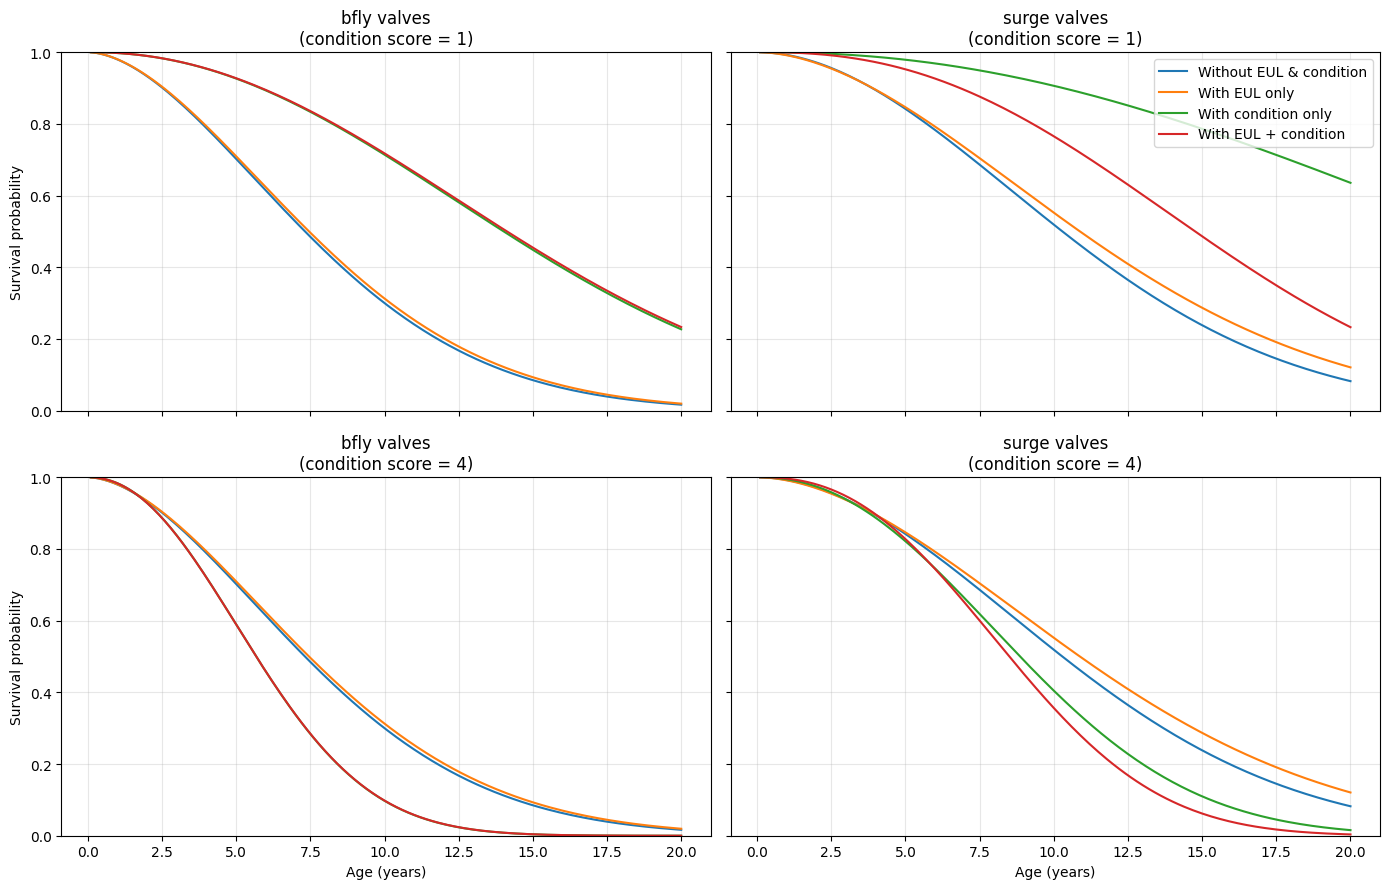

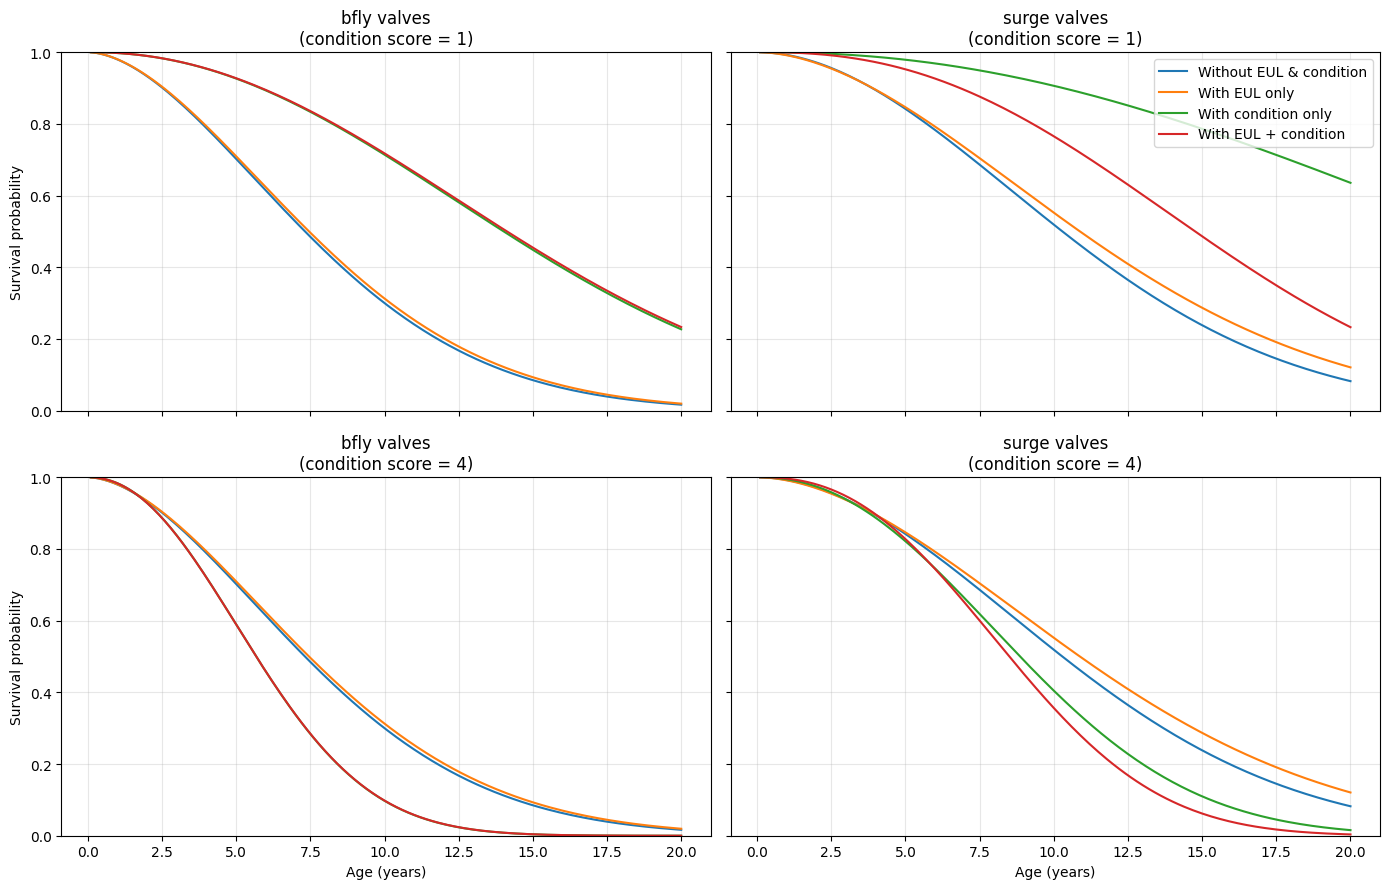

In [6]:
CONDITIONS_FOR_CURVES = (1, 4)
ages = np.linspace(0.1, 20.0, 200)


def survival_curve(
    model: dict[str, float], ages_years: np.ndarray, condition: int
) -> np.ndarray:
    k = model["k"]
    eta = model["eta"]
    beta = model["beta"]
    x = condition - 1.0
    return np.exp(-((ages_years / eta) ** k) * np.exp(beta * x))


asset_types = ("bfly valves", "surge valves")
fig, axes = plt.subplots(
    len(CONDITIONS_FOR_CURVES),
    len(asset_types),
    figsize=(14, 9),
    sharex=True,
    sharey=True,
)

for row, condition in enumerate(CONDITIONS_FOR_CURVES):
    for col, asset_type in enumerate(asset_types):
        ax = axes[row, col]
        for model_name, model in all_models[asset_type].items():
            ax.plot(ages, survival_curve(model, ages, condition), label=model_name)
        ax.set_title(f"{asset_type}\n(condition score = {condition})")
        ax.grid(alpha=0.3)

for col, asset_type in enumerate(asset_types):
    axes[-1, col].set_xlabel("Age (years)")
for row in range(len(CONDITIONS_FOR_CURVES)):
    axes[row, 0].set_ylabel("Survival probability")

axes[0, 0].set_ylim(0, 1)
axes[0, -1].legend(loc="upper right")
fig.tight_layout()
fig

## Summary

- Weibull PH handles ageing plus condition-score effects in one model.
- $c = 1$ is now the baseline hazard level, and each +1 score step multiplies
  hazard by $\exp(\beta)$.
- `EUL_SURVIVAL_PROBABILITY` is the explicit parameter that sets the EUL
  interpretation (`0.5` means EUL is median life).
- Comparing the four variants (none, EUL-only, condition-only, both) makes the
  incremental impact of each assumption visible for rich vs sparse asset types.